## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Business Understanding

The selling price of a home is a critical factor in the real estate market, as it directly influences the financial outcome for both buyers and sellers. For homeowners, the selling price represents the return on their investment and can significantly impact their financial well-being. Potential buyers, on the other hand, rely on the selling price to make informed decisions about purchasing a property within their budget and assessing its value relative to similar properties in the market.

House price is influenced by a multitude of factors, which can be broadly categorized into three main categories: property-specific factors, market factors, and external factors. Property-specific factors encompass attributes such as location, size, condition, amenities, architectural style, and age of the property. Market factors include supply and demand dynamics, interest rates, mortgage availability, and prevailing economic conditions. External factors can range from neighborhood characteristics, such as school quality and crime rates, to broader influences like government policies, infrastructure development, and demographic trends.

Understanding the factors that influence the selling price of residential properties is of paramount importance to various stakeholders involved in the real estate industry. Real estate agents need this knowledge to provide accurate pricing recommendations and effective marketing strategies for their clients. Homeowners can benefit from understanding these factors to make informed decisions when pricing their properties. Investors and developers can leverage this knowledge to identify promising investment opportunities and maximize their returns.

### Problem Statement
Real estate market is highly volatile, influenced by economic conditions, housing demand, and external factors. As such setting inappropriate prices and making uninformed decisions of when to sell a house can be counterproductive.  Research is essential to understand market trends and identify the best time to sell a home for maximizing its selling price. Analyzing property characteristics such as location, size, amenities, condition, and recent market trends through research aids in setting an appropriate selling price. By understanding how different home characteristics impact selling prices, the agency can help home owners mitigate the risk of setting inappropriate prices or making poor investment decisions.  

### Objectives
1. To understand factors that affect price of a house
2. To develop a model that can predict housing price based on various features.
3. To make recommendations on how home owners can optimize selling price of a house


In [1]:
# Reading dataset libraries
import pandas as pd  
import numpy as np 


# Visualization libraries
import seaborn as sns  
import matplotlib.pyplot as plt
%matplotlib inline  
import shap


# Modelling libaries
import statsmodels.api as sm  
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import lightgbm as lgb  


# Model evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error 
from sklearn.linear_model import LinearRegression



# Impute missing values
from sklearn.impute import SimpleImputer

# Statistical summary
# from pandas_profiling import ProfileReport



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/kc_house_data.csv', parse_dates=['date'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## <ins> Data Cleaning and Feature engineering </ins>

#### We decided not to drop any null values but rather introduce new categories for the missing values. Dropping columns may affect the model and in turn lead to biasness. Biased model salways have a poor accuracy when fed with real data or new data apart from that which it was trained on.

In [30]:
# Feature engineer new column from date
def engineer(data):
    df['year_sold'] = df['date'].dt.year
    df['difference'] = df['year_sold'] - df['yr_built']
    df['quarter'] = df['date'].dt.quarter
    return data 

# Function to get value counts for categorical columns.
def get_counts(data, column_name):
    try:
        return data[column_name].value_counts()
    except KeyError:
        raise ValueError(f"{column_name}' not found in the DataFrame.")
    
# Function to check for outliers
def check_outliers(data, columns):
    # Iterate over the specified columns
    for column in columns:
        # Calculate quartiles and interquartile range
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1

        # Outlier thresholds
        lower_threshold = q1 - 1.5 * iqr
        upper_threshold = q3 + 1.5 * iqr

        # Find outliers
        outliers = data[(data[column] < lower_threshold) | (data[column] > upper_threshold)]
    # Print the count of outliers
    print(column)
    print("Number of outliers:", len(outliers))

    


# Function to introduce seasons
# Function to map months to seasons
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'
# Execute the function.
df['seasons'] = df['date'].dt.month.apply(get_season)
    
# Function for imputing missing values. Handling missing values.
def impute_column(data, column, strategy='constant', fill_value='missing'):
    imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
    imputed_values = imputer.fit_transform(df[[column]])
    df[column] = imputed_values
    return data 

impute_column(df,'view', strategy='constant', fill_value='missing')

impute_column(df,'waterfront',strategy='constant', fill_value='missing')

# Mapping the view of houses according to weight.
area_view = {
    'missing': 0,
    'NONE': 1,
    'AVERAGE': 2,
    'GOOD': 3,
    'FAIR': 4,
    'EXCELLENT': 5
}
df['house_view_condition'] = df['view'].replace(area_view).astype(int)

# Map the housing conditions.
house_conditions = {
    'Poor': 0,
    'Average': 1,
    'Fair': 2,
    'Good': 3,
    'Very Good': 4
}
df['house_condition'] = df['condition'].replace(house_conditions).astype(int)

# Map the waterfronts.
fronts = {
    'missing': 0,
    'NO': 1,
    'YES': 2
}
df['waterfronts'] = df['waterfront'].replace(fronts).astype(int)

# Mapping seasons 
year_seasons = {
    'Winter':0,
    'Fall': 1,
    'Summer': 2,
    'Spring': 3
}
df['yr_season'] = df['seasons'].replace(year_seasons).astype(int)



In [4]:
df['year_sold'] = engineer(df['date']).dt.year
df['difference'] = engineer(df['year_sold'] - df['yr_built'])
df['quarter'] = engineer(df['date']).dt.quarter

In [5]:
print(get_counts(df,'waterfront'))

print(get_counts(df,'view'))

print(get_counts(df,'condition'))

print(get_counts(df,'sqft_basement'))

print(get_counts(df,'yr_renovated'))

NO         19075
missing     2376
YES          146
Name: waterfront, dtype: int64
NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
missing         63
Name: view, dtype: int64
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64
0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64
0.0       17011
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64


In [ ]:
# Print the count of outliers
print(column)
print("Number of outliers:", len(outliers))


In [6]:

impute_column(df,'view',strategy='constant', fill_value='missing')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,house_view_condition,house_condition,waterfronts,year_sold,difference,quarter
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,missing,NONE,...,47.5112,-122.257,1340,5650,1,1,0,2014,59,4
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,47.7210,-122.319,1690,7639,1,1,1,2014,63,4
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,47.7379,-122.233,2720,8062,1,1,1,2015,82,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,47.5208,-122.393,1360,5000,1,4,1,2014,49,4
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,47.6168,-122.045,1800,7503,1,1,1,2015,28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,47.6993,-122.346,1530,1509,1,1,1,2014,5,2
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,47.5107,-122.362,1830,7200,1,1,1,2015,1,1
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,47.5944,-122.299,1020,2007,1,1,1,2014,5,2
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,missing,NONE,...,47.5345,-122.069,1410,1287,1,1,0,2015,11,1


In [7]:
impute_column(df,'waterfront',strategy='constant', fill_value='missing')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,house_view_condition,house_condition,waterfronts,year_sold,difference,quarter
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,missing,NONE,...,47.5112,-122.257,1340,5650,1,1,0,2014,59,4
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,47.7210,-122.319,1690,7639,1,1,1,2014,63,4
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,47.7379,-122.233,2720,8062,1,1,1,2015,82,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,47.5208,-122.393,1360,5000,1,4,1,2014,49,4
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,47.6168,-122.045,1800,7503,1,1,1,2015,28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,47.6993,-122.346,1530,1509,1,1,1,2014,5,2
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,47.5107,-122.362,1830,7200,1,1,1,2015,1,1
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,47.5944,-122.299,1020,2007,1,1,1,2014,5,2
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,missing,NONE,...,47.5345,-122.069,1410,1287,1,1,0,2015,11,1


In [8]:
# Feature engineering
df['gradings'] = df['grade'].str.extract(r'(\d+)').astype(int)

df['total_sqft'] = df['sqft_living'] + df['sqft_lot']

df['neighborhood_avg_living_space'] = df['sqft_living15'].mean()


In [9]:
# Interpolation by calculating by estimating value of null values.
df['yr_renovated'].interpolate()

0           0.0
1        1991.0
2         995.5
3           0.0
4           0.0
          ...  
21592       0.0
21593       0.0
21594       0.0
21595       0.0
21596       0.0
Name: yr_renovated, Length: 21597, dtype: float64

In [10]:
# Fill missing values 
df['yr_renovated'].fillna(0, inplace=True)

In [11]:
df['sqft_basement'] = df['sqft_basement'].replace('?',0)

In [12]:
# Convert object data type to integer data type. 
df['sqft_basement']  = pd.to_numeric(df['sqft_basement'], errors='coerce').astype(int)

In [14]:
# Checking for duplicates
duplicate_rows = df[df.duplicated()]
# Print the duplicate rows
print(duplicate_rows)

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, house_view_condition, house_condition, waterfronts, year_sold, difference, quarter, gradings, total_sqft, neighborhood_avg_living_space, seasons]
Index: []

[0 rows x 31 columns]


#### Outliers
##### Outliers were checked only for numerical discrete and continuous variables.  Categorical variables do not have numerical order hence cannot be checked for outliers. ALso `yr_built` `yr_renovated`,  `zipcode`, `lat`  and  `long`  were exlcuded given it makes sense to check for incosistencies than outliers

In [15]:
# columns to check for outliers
columns_to_check = ['price', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

# Call the function to check outliers and print the results
check_outliers(df, columns_to_check)

price
Number of outliers: 1158

sqft_lot
Number of outliers: 2419

sqft_above
Number of outliers: 610

sqft_living15
Number of outliers: 543

sqft_lot15
Number of outliers: 2188



In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             21597 non-null  int64         
 1   date                           21597 non-null  datetime64[ns]
 2   price                          21597 non-null  float64       
 3   bedrooms                       21597 non-null  int64         
 4   bathrooms                      21597 non-null  float64       
 5   sqft_living                    21597 non-null  int64         
 6   sqft_lot                       21597 non-null  int64         
 7   floors                         21597 non-null  float64       
 8   waterfront                     21597 non-null  object        
 9   view                           21597 non-null  object        
 10  condition                      21597 non-null  object        
 11  grade          

### <ins> Data visualization </ins>

### <ins> Modelling </ins>

#### <ins> Simple linear Regression </ins>

In [17]:
X_baseline = df['sqft_living']
y_baseline = df['price']

baseline_model = sm.OLS(y_baseline, sm.add_constant(X_baseline)).fit()
print(baseline_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:14:46   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      

#### Evaluating Model Performance using Durbin-Watson.
 * The model has a Durbin-Watson of 1.979 which shows that there is no significant autocorrelation.


### Interpretation of the model

* With an F-statistic p-value below 0.05, the overall model is `statistically significant`

* The results show that sqft_living explains `49.3%` variation in price of houses.

* The model coefficients (`const` and `sqft_living`) are both statistically significant, with p-values  below 0.05

* An increase of 1 square foot in the living area leads to a price increase of approximately $280.


 ####  The model with sqft_living as the independent variable only explains 49% variation in price. As such there is need for more variables to explain more variation and make more accurate prediction.

##### <ins> Multiple regression with unlogged target </ins>

In [18]:
# Baseline Linear Regression model
X = df[['sqft_living','gradings','difference','house_condition','bathrooms','sqft_living15','house_view_condition','lat','long']]
y= df['price']

model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     4947.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:14:46   Log-Likelihood:            -2.9530e+05
No. Observations:               21597   AIC:                         5.906e+05
Df Residuals:                   21587   BIC:                         5.907e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.956e+07 

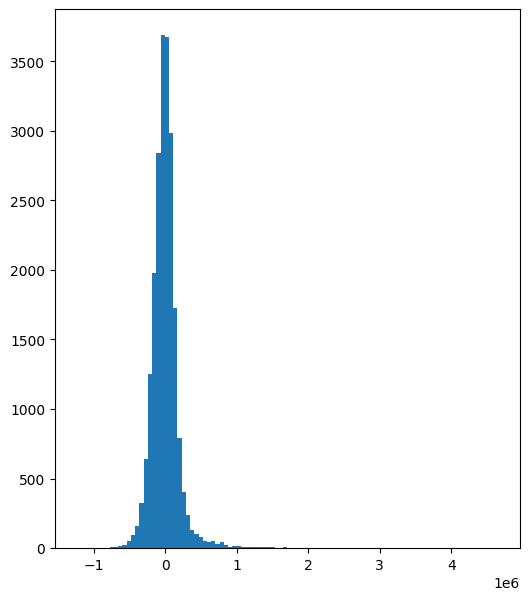

In [19]:
fig = plt.figure(figsize=(6,7))
plt.hist(model.resid, bins=100)
plt.show()

#### All the p-values for the predictors are lower than 0.05 and this makes the features significant. The model also has a p-value less than 0.05 and thereby the model is significant.

#### The residuals also have a normal distribution thereby satisfying all the assumptons of a linear regression model.

#### <ins> Model with Log transformed target </ins>

In [20]:
# Log transformed model
X = df[['sqft_living','gradings','difference','house_condition','bathrooms','lat','house_view_condition','sqft_living15','long']]
y = np.log(df['price'])

log_model = sm.OLS(y, sm.add_constant(X)).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     7572.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:14:48   Log-Likelihood:                -1406.8
No. Observations:               21597   AIC:                             2834.
Df Residuals:                   21587   BIC:                             2913.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -58.6859 

#### The model's predictors p_values all have values lower than 0.05 making them all significant.


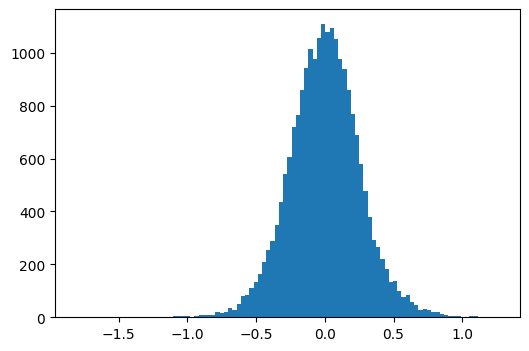

In [21]:
# The residuals follow a normal distribution
fig = plt.figure(figsize=(6,4))
plt.hist(log_model.resid, bins=100)
plt.show()

#### Plotting the residuals shows a normal distribution. This satisfies the linear regression assumption of normality of residuals.

#### <ins> Scikit-learn model </ins>

In [22]:
# ScikitLearn model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

lr = LinearRegression()
model_scikit_learn = lr.fit(X_train,y_train)

y_pred = model_scikit_learn.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2) Score: {r2}")


Mean Squared Error: 0.06753112152001804
R-squared (R2) Score: 0.752044836831647


In [23]:
# Hyperparameter tuning using KFold validation.
kfold_validation = KFold(20)
cross_results = cross_val_score(lr, X_train,y_train, cv=kfold_validation)
print(np.mean(cross_results))

0.7600967907658769


##### The scikit-learn model has a perfomance of 75% on the test data which is the unforeseen data. Hypeparameter tuning with K fold validation yields a 76% accuracy.

#### <ins> LightGBM regression model </ins>

In [24]:
# Light GBM model  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train,y_train)

y_pred_lgbm = lgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lgbm)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(y_test, y_pred_lgbm)

print(f"R-squared (R2) Score: {r2:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 17277, number of used features: 9
[LightGBM] [Info] Start training from score 13.049754
Mean Squared Error (MSE): 0.03055994423607785
R-squared (R2) Score: 0.89


In [25]:
# Append the test and predicted dataframes into a CSV.
df2 = pd.DataFrame({'test_prices':y_test,'pred_prices':y_pred_lgbm})
df2.to_csv("final.csv", header=True, index=False)
df2.head()

,test_prices,pred_prices
3686,11.794338,12.035085
10247,12.936034,12.931805
4037,13.110291,12.926569
3437,12.779873,12.743138
19291,13.314635,13.250247


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

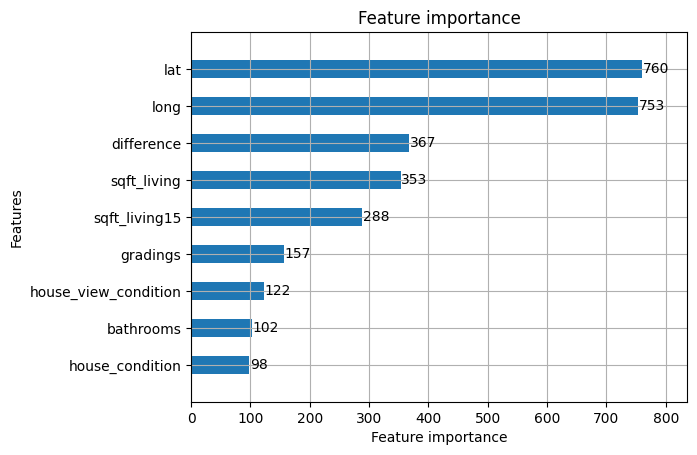

In [26]:
# Plot the features that influence house prices.
lgb.plot_importance(lgb_model, height=.5)

<AxesSubplot: title={'center': 'LightGBM feature importance (gain)'}, xlabel='Feature importance', ylabel='Features'>

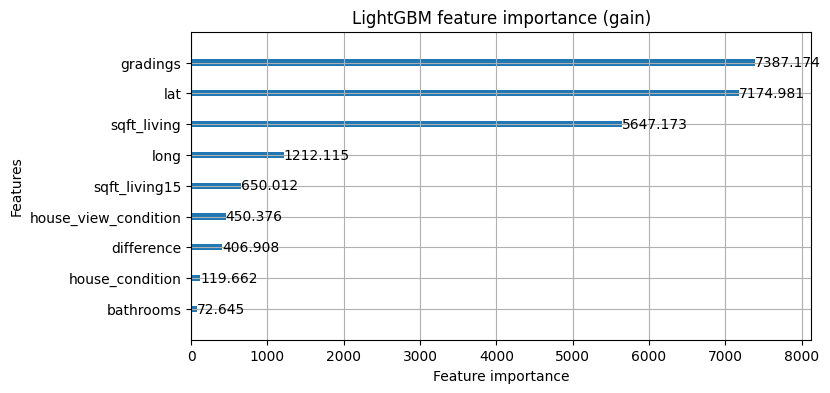

In [27]:
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(8,4),title="LightGBM feature importance (gain)")
# lgb.plot_importance(lgb_model, height=0.5, title="LightGBM feature importance (gain)")


##### The main difference between the split and gain plots is that the split plot(1st) measures how often a feature is used in the decision trees during training while the gain plot(2nd) shows the feature importance based on the gain in accuracy achieved. There might be slight changes in values for both plots because they explain different metrics. This plot explains the SHAP figure below.

##### A Plot of the SHAP values offers good visualization of how the independent variables vary with the target variable(Price) of the model. It offers more insights of the predictors contributions to the overall model performance unlike the feature importance plot above. The Latitude which signifies location, the house gradings, and the living room space have massive influence on the price of the houses. 

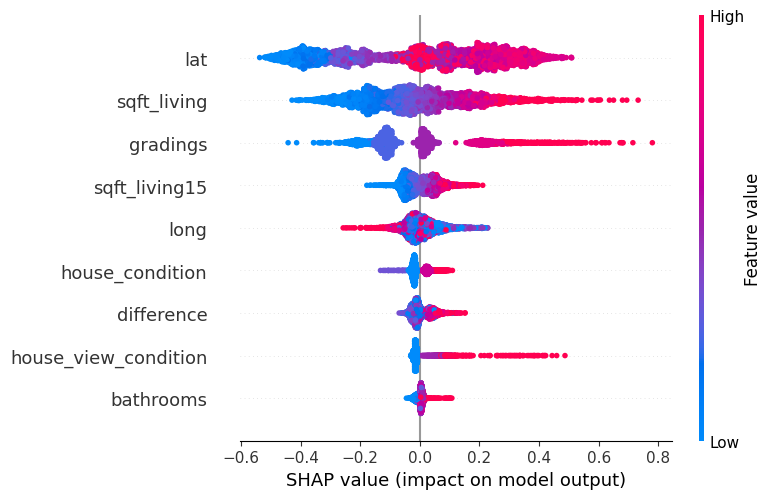

In [28]:
explainer = shap.TreeExplainer(lgb_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

##### Plot Understanding: The plot confirms that as the gradings in houses increases so does the price, as the size of the living space increases sodoes the price, as the location(Lat) changes so does the price, as the neighborhood living space increases so does the price, and finally as the house view condition improves so does the price of the houses.

##### The plot confirms everything we know from domain knowledge. This means our model is making the correct assumptions.

#### LightGBM performance is better than StatsModels and Scikit-learn with a score of 86%. We used LightGBM because: 
* It offers a higher accuracy by combining multiple decision trees to create a strong predictive model and handles overfitting well.
* It provides feature importance plots(splits and gains) which are very vital to knowing the most important features. 
* It handles categorical features better than the models used above.
* It is very efficient in handling both large and small datasets and therefore the go to method where computational power and accuracy is of concern. especially 

##### LightGBM also uses parallel computing which offers high accuracies with fast training speeds and has a low memory utilization. Should the model be put into production, it will be very efficient in handling large housing datasets and provide good accuracies to the King County Real Estate community in terms of determing pricing of homes.

#### <ins> Conclusion </ins>

##### From the feature importance plots, the top four main factors driving house prices in the King county region include: 

* The location of houses.
* The squarefeet of living room and that of neighbors..
* The house view condition 
* The time taken to sell the house.
